# Many model comparison

This notebook piggybacks off off the [cartesian infrastructure](https://github.com/matsengrp/torchdms-experiments/tree/master/tdmsex/scripts) for training `torchdms` models. It collects all the models into a descriptive dataframe, and then predicts on the octet data from the victora lab. Here, we are predicting on higher-order, higher affinity mutants to find possible causes for "the wall" (i.e. models _stochastically_ seem to have a ceiling on predicting phenotypes - and it depends mostly on the seed). While we're targetting the octet dataset, this same infrastructure could be used for hyper-parameter tuning and testing for model consistany in other contexts, as well.

In [87]:
import pickle
import json
import os
import sys
import glob
from functools import reduce
from collections import defaultdict
import warnings
from datetime import date
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
%matplotlib inline

import torch
from Bio.Seq import Seq
from Bio import SeqIO
import binarymap
from tqdm import tqdm

## 1. Define Paths

We'll define where we're getting our models, and where the relavent datasets are.

In [107]:
exp_rhino_path = "/home/jgallowa/Projects/torchdms/torchdms-experiments/experiments"
exps = [
    "2022-06-27-monotonic-sigmoid-replicates"
]

# all the GE training (and testing) data organized with everything you could need
dms_final_prepped_scores_path = "data/torchdms/prepped-dms/final-multi-variant-scores.csv"

# Observed seqs from replay
replay_observed_seqs_path = "results/latest/merged-results/observed-seqs.csv"

# All tree node data.
replay_tree_seqs_path = "results/latest/merged-results/gctree-node-data.csv"

# position map
naive_sites_path = "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv"

plot_dir = f"{exps[0]}_eval_plots"

In [108]:
! mkdir -p {plot_dir}
! rm -rf {exps[0]}

## 2. `rsync` all .model files

In [109]:
for exp in exps:
    ! rsync -v -a -m --include='**/*.model' --include='*/' --include='**/*.csv' --exclude='*' --ignore-existing \
        jgallowa@rhino.fhcrc.org:{exp_rhino_path}/{exp}/_output {exp}

receiving file list ... done
created directory 2022-06-27-monotonic-sigmoid-replicates
_output/
_output/loss_fn@mse/
_output/loss_fn@mse/model_string@ConditionalSequential;[1_3];[None_'sigmoid']/
_output/loss_fn@mse/model_string@ConditionalSequential;[1_3];[None_'sigmoid']/seed@0/
_output/loss_fn@mse/model_string@ConditionalSequential;[1_3];[None_'sigmoid']/seed@0/CGG-octet-cali-sceil-3.error-summary.csv
_output/loss_fn@mse/model_string@ConditionalSequential;[1_3];[None_'sigmoid']/seed@0/CGG-octet-cali-sceil-3.error.csv
_output/loss_fn@mse/model_string@ConditionalSequential;[1_3];[None_'sigmoid']/seed@0/CGG-octet-cali-sceil-3.model
_output/loss_fn@mse/model_string@ConditionalSequential;[1_3];[None_'sigmoid']/seed@0/CGG-octet-cali-sceil-3.scatter.corr.csv
_output/loss_fn@mse/model_string@ConditionalSequential;[1_3];[None_'sigmoid']/seed@1/
_output/loss_fn@mse/model_string@ConditionalSequential;[1_3];[None_'sigmoid']/seed@1/CGG-octet-cali-sceil-3.error-summary.csv
_output/loss_fn@mse/mod

_output/loss_fn@mse/model_string@FullyConnected;[2_3];[None_'sigmoid']/seed@0/CGG-octet-cali-sceil-3.model
_output/loss_fn@mse/model_string@FullyConnected;[2_3];[None_'sigmoid']/seed@0/CGG-octet-cali-sceil-3.scatter.corr.csv
_output/loss_fn@mse/model_string@FullyConnected;[2_3];[None_'sigmoid']/seed@1/
_output/loss_fn@mse/model_string@FullyConnected;[2_3];[None_'sigmoid']/seed@1/CGG-octet-cali-sceil-3.error-summary.csv
_output/loss_fn@mse/model_string@FullyConnected;[2_3];[None_'sigmoid']/seed@1/CGG-octet-cali-sceil-3.error.csv
_output/loss_fn@mse/model_string@FullyConnected;[2_3];[None_'sigmoid']/seed@1/CGG-octet-cali-sceil-3.model
_output/loss_fn@mse/model_string@FullyConnected;[2_3];[None_'sigmoid']/seed@1/CGG-octet-cali-sceil-3.scatter.corr.csv
_output/loss_fn@mse/model_string@FullyConnected;[2_3];[None_'sigmoid']/seed@2/
_output/loss_fn@mse/model_string@FullyConnected;[2_3];[None_'sigmoid']/seed@2/CGG-octet-cali-sceil-3.error-summary.csv
_output/loss_fn@mse/model_string@FullyConne

_output/loss_fn@mse/model_string@Independent;[1_3];[None_'sigmoid']/
_output/loss_fn@mse/model_string@Independent;[1_3];[None_'sigmoid']/seed@0/
_output/loss_fn@mse/model_string@Independent;[1_3];[None_'sigmoid']/seed@0/CGG-octet-cali-sceil-3.error-summary.csv
_output/loss_fn@mse/model_string@Independent;[1_3];[None_'sigmoid']/seed@0/CGG-octet-cali-sceil-3.error.csv
_output/loss_fn@mse/model_string@Independent;[1_3];[None_'sigmoid']/seed@0/CGG-octet-cali-sceil-3.model
_output/loss_fn@mse/model_string@Independent;[1_3];[None_'sigmoid']/seed@0/CGG-octet-cali-sceil-3.scatter.corr.csv
_output/loss_fn@mse/model_string@Independent;[1_3];[None_'sigmoid']/seed@1/
_output/loss_fn@mse/model_string@Independent;[1_3];[None_'sigmoid']/seed@1/CGG-octet-cali-sceil-3.error-summary.csv
_output/loss_fn@mse/model_string@Independent;[1_3];[None_'sigmoid']/seed@1/CGG-octet-cali-sceil-3.error.csv
_output/loss_fn@mse/model_string@Independent;[1_3];[None_'sigmoid']/seed@1/CGG-octet-cali-sceil-3.model
_output/

_output/loss_fn@mse/model_string@Independent;[1_6_6];[None_'sigmoid'_'sigmoid']/seed@5/CGG-octet-cali-sceil-3.scatter.corr.csv
_output/loss_fn@mse/model_string@Independent;[1_6_6];[None_'sigmoid'_'sigmoid']/seed@6/
_output/loss_fn@mse/model_string@Independent;[1_6_6];[None_'sigmoid'_'sigmoid']/seed@6/CGG-octet-cali-sceil-3.error-summary.csv
_output/loss_fn@mse/model_string@Independent;[1_6_6];[None_'sigmoid'_'sigmoid']/seed@6/CGG-octet-cali-sceil-3.error.csv
_output/loss_fn@mse/model_string@Independent;[1_6_6];[None_'sigmoid'_'sigmoid']/seed@6/CGG-octet-cali-sceil-3.model
_output/loss_fn@mse/model_string@Independent;[1_6_6];[None_'sigmoid'_'sigmoid']/seed@6/CGG-octet-cali-sceil-3.scatter.corr.csv
_output/loss_fn@mse/model_string@Independent;[1_6_6];[None_'sigmoid'_'sigmoid']/seed@7/
_output/loss_fn@mse/model_string@Independent;[1_6_6];[None_'sigmoid'_'sigmoid']/seed@7/CGG-octet-cali-sceil-3.error-summary.csv
_output/loss_fn@mse/model_string@Independent;[1_6_6];[None_'sigmoid'_'sigmoid'

In [110]:
! tree -L 3 {exp}/

2022-06-27-monotonic-sigmoid-replicates/
└── _output
    └── loss_fn@mse
        ├── model_string@ConditionalSequential;[1_3];[None_'sigmoid']
        ├── model_string@ConditionalSequential;[1_6_6];[None_'sigmoid'_'sigmoid']
        ├── model_string@FullyConnected;[2_3];[None_'sigmoid']
        ├── model_string@FullyConnected;[2_6_6];[None_'sigmoid'_'sigmoid']
        ├── model_string@Independent;[1_3];[None_'sigmoid']
        ├── model_string@Independent;[1_6_6];[None_'sigmoid'_'sigmoid']
        └── model_string@Linear

9 directories, 0 files


## 3. Make Model DataFrame (`model_df`) 

Make a dataframe that hold all the binary torch models and their defining annotations.

In [159]:
# collect the models
models = defaultdict(list)
for i, path in enumerate(glob.glob(f'{exp}/**/*.model', recursive=True)):
    dir_struct = path.split("/")
    models["model_name"].append(dir_struct[-1])
    models["model"].append(torch.load(path, map_location="cpu"))
    for des in dir_struct[2:-1]:
        param, value = des.split("@")
        models[param].append(value)

model_df = pd.DataFrame(models)
model_df = model_df.assign(model_id=range(len(model_df)))
model_df

,model_name,model,loss_fn,model_string,seed,model_id
0,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],2,0
1,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],5,1
2,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],4,2
3,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],8,3
4,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],0,4
...,...,...,...,...,...,...
65,CGG-octet-cali-sceil-3.model,ConditionalSequential(\n (model_bind): FullyC...,mse,ConditionalSequential;[1_3];[None_'sigmoid'],3,65
66,CGG-octet-cali-sceil-3.model,ConditionalSequential(\n (model_bind): FullyC...,mse,ConditionalSequential;[1_3];[None_'sigmoid'],7,66
67,CGG-octet-cali-sceil-3.model,ConditionalSequential(\n (model_bind): FullyC...,mse,ConditionalSequential;[1_3];[None_'sigmoid'],1,67
68,CGG-octet-cali-sceil-3.model,ConditionalSequential(\n (model_bind): FullyC...,mse,ConditionalSequential;[1_3];[None_'sigmoid'],6,68


In [112]:
# model_df = model_df.assign(loss_fn = "mse")

In [162]:
lmtd = [idx for idx, row in model_df.iterrows() if "6_6" in row.model_string]
model_df = model_df.drop(lmtd)

## 4. Collect final variant scores

The final multi variant scores is the complete dataframe with all sequences used to train out GE models

In [163]:
# load the Final mutant variant scores used in training
final_multi_variant_scores = (
    pd.read_csv(dms_final_prepped_scores_path)
#     .rename({"delta_stab": "delta_expr"}, axis=1)
    .reset_index()
)
id_vars = [
    "aa_sequence", 
    "n_aa_substitutions",
    "aa_substitutions_IMGT", 
    "aa_substitutions", 
    "delta_bind_CGG", 
    "delta_expr",
    "delta_psr",
    "split_set",
    "library"
]
fmvs = final_multi_variant_scores[id_vars]
fmvs

,aa_sequence,n_aa_substitutions,aa_substitutions_IMGT,aa_substitutions,delta_bind_CGG,delta_expr,delta_psr,split_set,library
0,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,A100(H)T T5(L)L,A91T T132L,-1.120389,-1.225703,1.614845,test,dms
1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,A105(H)T D107(H)S,A96T D98S,-0.583298,0.062470,0.589685,test,dms
2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,C23(L)W E97(L)C,C150W E208C,-1.318972,-2.448595,1.309087,test,dms
3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,3,C23(H)H S7(L)R G16(L)P,C22H S134R G143P,NaN,-3.872965,1.305743,test,dms
4,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,3,C23(H)N S29(H)T I126(L)T,C22N S28T I233T,-1.070922,-1.750284,0.657205,test,dms
...,...,...,...,...,...,...,...,...,...
16705,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,4,A40(L)G Y42(L)F A52(L)S N108(L)Y,A161G Y163F A173S N219Y,2.562305,NaN,NaN,train,octet
16706,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,5,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,A161G Y163F A173S Q216H N219Y,2.690806,NaN,NaN,train,octet
16707,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,4,A40(L)G Y42(L)F A52(L)S N108(L)S,A161G Y163F A173S N219S,2.423506,NaN,NaN,train,octet
16708,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,5,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)S,A161G Y163F A173S Q216H N219S,2.428066,NaN,NaN,train,octet


## 5. Add each models Predictions to the dms variant scores

For each of the models, we'll predict on all sequences in the 

In [164]:
# get the one hot encodings for each
a_model = model_df.loc[0, "model"]
aa_seq_one_hot = torch.stack(
    list(fmvs.aa_sequence.apply(lambda seq: a_model.seq_to_binary(seq)).values)
)
aa_seq_one_hot

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [165]:
aa_seq_one_hot.shape

torch.Size([16710, 4935])

In [166]:
for idx, row in tqdm(model_df.iterrows(), total=len(model_df)):
    bind_str = f"{row.model_id}-delta-bind_CGG"
    expr_str = f"{row.model_id}-delta-expr"
    fmvs[[bind_str, expr_str]] = row.model(aa_seq_one_hot).detach().numpy()
fmvs

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.21it/s]


,aa_sequence,n_aa_substitutions,aa_substitutions_IMGT,aa_substitutions,delta_bind_CGG,delta_expr,delta_psr,split_set,library,0-delta-bind_CGG,...,65-delta-bind_CGG,65-delta-expr,66-delta-bind_CGG,66-delta-expr,67-delta-bind_CGG,67-delta-expr,68-delta-bind_CGG,68-delta-expr,69-delta-bind_CGG,69-delta-expr
0,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,A100(H)T T5(L)L,A91T T132L,-1.120389,-1.225703,1.614845,test,dms,-1.358302,...,-0.993837,-1.488010,-0.972009,-1.501694,-0.992528,-1.493863,-1.006099,-1.483856,-1.000685,-1.495429
1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,A105(H)T D107(H)S,A96T D98S,-0.583298,0.062470,0.589685,test,dms,-1.930316,...,-2.840033,-0.577035,-2.897463,-0.572087,-2.864255,-0.563639,-2.094191,-0.563626,-2.830100,-0.585450
2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,C23(L)W E97(L)C,C150W E208C,-1.318972,-2.448595,1.309087,test,dms,-1.385786,...,-0.808666,-2.082641,-0.806840,-2.076446,-0.796086,-2.086775,-1.024288,-2.087879,-0.809788,-2.077162
3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,3,C23(H)H S7(L)R G16(L)P,C22H S134R G143P,NaN,-3.872965,1.305743,test,dms,-1.473880,...,-1.633264,-1.543597,-1.499477,-1.544915,-1.616828,-1.533180,-1.616434,-1.530863,-1.634453,-1.555762
4,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,3,C23(H)N S29(H)T I126(L)T,C22N S28T I233T,-1.070922,-1.750284,0.657205,test,dms,-1.890493,...,-0.951168,-2.443559,-0.879007,-2.418117,-0.918707,-2.414180,-1.129084,-2.417403,-0.942543,-2.432374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16705,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,4,A40(L)G Y42(L)F A52(L)S N108(L)Y,A161G Y163F A173S N219Y,2.562305,NaN,NaN,train,octet,2.493050,...,2.618915,-0.592470,2.614542,-0.585981,2.622343,-0.559185,2.639208,-0.558409,2.625128,-0.603778
16706,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,5,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,A161G Y163F A173S Q216H N219Y,2.690806,NaN,NaN,train,octet,2.557446,...,2.693527,-0.633258,2.693956,-0.627564,2.697622,-0.595160,2.696546,-0.587839,2.700670,-0.648457
16707,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,4,A40(L)G Y42(L)F A52(L)S N108(L)S,A161G Y163F A173S N219S,2.423506,NaN,NaN,train,octet,2.398830,...,2.405866,-0.382136,2.407791,-0.376689,2.408487,-0.356874,2.430364,-0.347320,2.411224,-0.398380
16708,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,5,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)S,A161G Y163F A173S Q216H N219S,2.428066,NaN,NaN,train,octet,2.468068,...,2.486072,-0.423368,2.493537,-0.418757,2.489304,-0.393243,2.500947,-0.377052,2.492589,-0.443578


## 6. Evaluate the accuracy of all models

In [167]:
def MAE(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

subsets = {
    "single_mutants" : "n_aa_substitutions == 1",
    "held_out_test" : "split_set == 'test'",
    "dms_calibrated_octet" : "library == 'octet'"
}

# add corr and mae to each model, for each data subset
for dataset, query in subsets.items():
    eval_variants = fmvs.query(query)
    for idx, model_row in model_df.iterrows():
        for ax_row, pheno in enumerate(["bind_CGG", "expr"]):
            model_pred_str = f"{model_row.model_id}-delta-{pheno}"
            ground_truth_str = f"delta_{pheno}"
            rela = eval_variants[[ground_truth_str, model_pred_str]].dropna()
            if len(rela) == 0: continue
            true = rela[ground_truth_str]
            pred = rela[model_pred_str]
            r = sp.pearsonr(true, pred)[0]
            model_df.loc[idx, f"{dataset}_{pheno}_corr"] = sp.pearsonr(true, pred)[0]
            model_df.loc[idx, f"{dataset}_{pheno}_mae"] = MAE(true, pred)

model_df

,model_name,model,loss_fn,model_string,seed,model_id,single_mutants_bind_CGG_corr,single_mutants_bind_CGG_mae,single_mutants_expr_corr,single_mutants_expr_mae,held_out_test_bind_CGG_corr,held_out_test_bind_CGG_mae,held_out_test_expr_corr,held_out_test_expr_mae,dms_calibrated_octet_bind_CGG_corr,dms_calibrated_octet_bind_CGG_mae
0,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],2,0,0.824092,0.278043,0.770994,0.231091,0.744752,0.611247,0.641632,0.662996,0.992632,0.167477
1,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],5,1,0.939084,0.175336,0.955106,0.127236,0.801608,0.558353,0.832818,0.446170,0.994268,0.103535
2,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],4,2,0.823456,0.277549,0.772353,0.230355,0.744685,0.608925,0.640850,0.661941,0.992946,0.163515
3,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],8,3,0.941016,0.171334,0.956385,0.127392,0.798148,0.557893,0.837498,0.438546,0.993218,0.111098
4,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],0,4,0.818088,0.278361,0.778488,0.228116,0.743098,0.603418,0.648372,0.655396,0.990477,0.189453
5,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],3,5,0.822850,0.275158,0.774558,0.229528,0.743633,0.606469,0.646218,0.657112,0.990909,0.180582
6,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],7,6,0.818441,0.278405,0.777832,0.228353,0.742691,0.604197,0.647582,0.656369,0.990983,0.184554
7,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],1,7,0.942093,0.171757,0.954687,0.129454,0.799399,0.557723,0.831889,0.450488,0.994072,0.103593
8,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],6,8,0.941062,0.162879,0.957615,0.126798,0.802296,0.545347,0.839247,0.436309,0.990405,0.134240
9,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],9,9,0.795335,0.285885,0.797313,0.225980,0.734792,0.601013,0.668837,0.647204,0.986572,0.208714


## 7. Plot Model Correlation Values

In [168]:
model_eval_id_vars = [
    'model_name',
    'model', 
    'loss_fn', 
    'model_string', 
    'seed', 
    'model_id'
]
# still having some problems with monotonic models
model_df_tall = pd.melt(model_df, model_eval_id_vars)
model_df_tall = model_df_tall.assign(model_string = ["\n".join(st.split(";")) for st in model_df_tall.model_string.values])

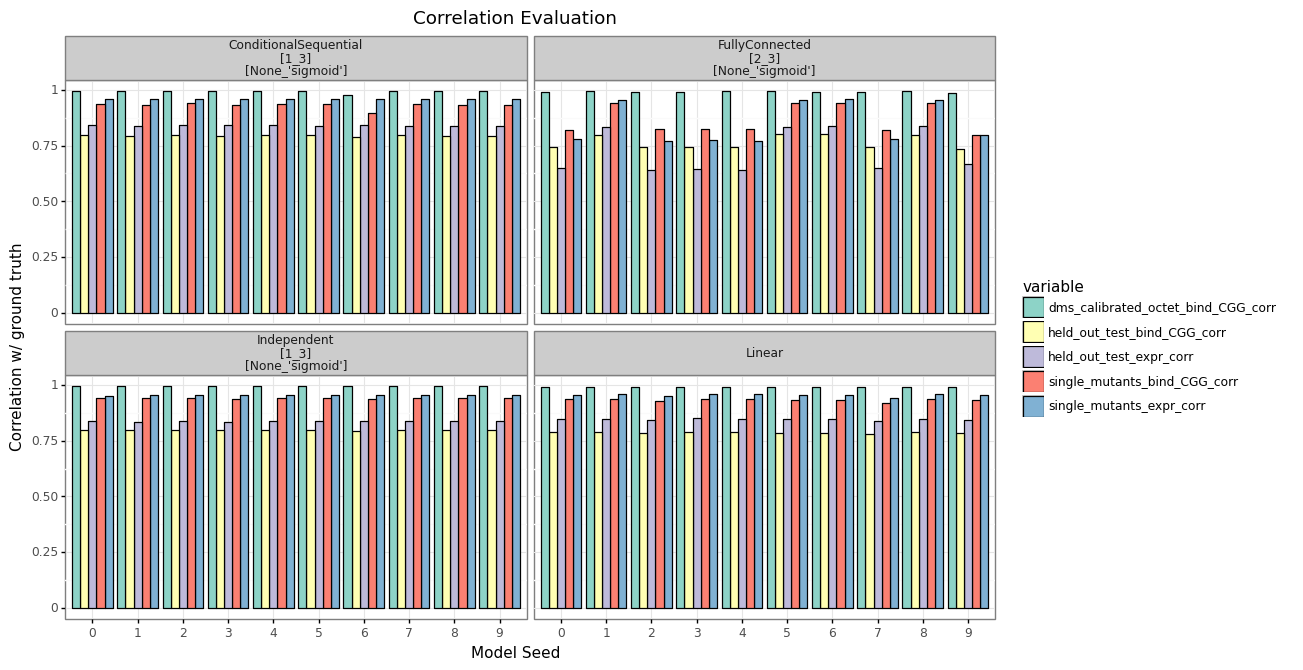

In [169]:

g = (
    ggplot(
        model_df_tall.query(
            f"variable.isin({[c for c in model_df.columns if 'corr' in c]})"
        )
    )
    + aes(
        x='factor(seed)',
#         group="monotonic",
        y='value',
        fill='variable'
    )
    + geom_col(
        stat='identity', 
        position='dodge',
        color="black"
    )
    + facet_wrap("model_string")
    + theme_bw()
    + theme(
        figure_size=[12, 7]
    )
    + labs(
        title = "Correlation Evaluation",
        x = "Model Seed",
        y = "Correlation w/ ground truth"
    )
    + scale_fill_brewer(type="qual", palette="Set3")
)
g.draw()
# g.save("col-corr.png")
g.save(f"{plot_dir}/column_reps_corr.png")

plt.show()

## 8. Plot Model Correlation Values

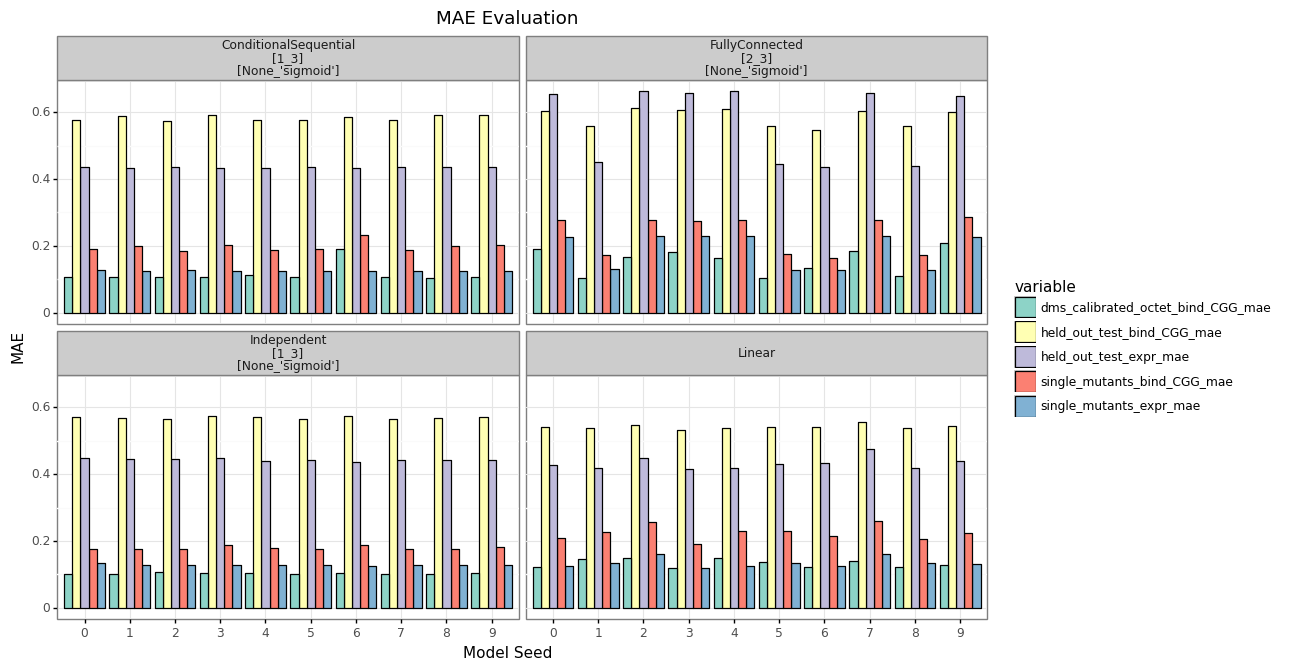

In [170]:
g = (
    ggplot(
        model_df_tall.query(
            f"variable.isin({[c for c in model_df.columns if 'mae' in c]})"
        )
    )
    + aes(
        x='factor(seed)', 
        y='value',
        fill='variable'
    )
    + geom_col(
        stat='identity', 
        position='dodge',
        color="black"
    )
    + facet_wrap("model_string")
    + theme_bw()
    + theme(
        figure_size=[12, 7]
    )
    + labs(
        title = "MAE Evaluation",
        x = "Model Seed",
        y = "MAE"
    )
    + scale_fill_brewer(type="qual", palette="Set3")
#     + ylim(0,0.5)
)
g.draw()
g.save(f"{plot_dir}/column_reps_mae.png")

plt.show()

## 9. Best Model Comparison (+ additive comp)

In [171]:
# choose the best models right now based upon lowest MAE on held out test set ... 
best_idx = []
for models, models_df in model_df.groupby(["model_string"]):
    best_idx.append(
        models_df[models_df.held_out_test_bind_CGG_mae == min(models_df.held_out_test_bind_CGG_mae)].index.values[0]
    )
best_models = model_df.loc[best_idx]

In [172]:
best_models

,model_name,model,loss_fn,model_string,seed,model_id,single_mutants_bind_CGG_corr,single_mutants_bind_CGG_mae,single_mutants_expr_corr,single_mutants_expr_mae,held_out_test_bind_CGG_corr,held_out_test_bind_CGG_mae,held_out_test_expr_corr,held_out_test_expr_mae,dms_calibrated_octet_bind_CGG_corr,dms_calibrated_octet_bind_CGG_mae
60,CGG-octet-cali-sceil-3.model,ConditionalSequential(\n (model_bind): FullyC...,mse,ConditionalSequential;[1_3];[None_'sigmoid'],2,60,0.939890,0.185406,0.957958,0.126708,0.797625,0.573531,0.840479,0.435648,0.993813,0.105801
8,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_3];[None_'sigmoid'],6,8,0.941062,0.162879,0.957615,0.126798,0.802296,0.545347,0.839247,0.436309,0.990405,0.134240
20,CGG-octet-cali-sceil-3.model,Independent(\n (model_bind): FullyConnected(\...,mse,Independent;[1_3];[None_'sigmoid'],2,20,0.943199,0.177434,0.954906,0.129825,0.797576,0.565241,0.837002,0.444475,0.994395,0.106055
45,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,3,45,0.939022,0.192468,0.959262,0.120409,0.790063,0.533643,0.850662,0.416773,0.993000,0.118138


In [173]:
sample_colormap="Dark2"
cmap=plt.get_cmap(sample_colormap)
order = sorted(list(fmvs.n_aa_substitutions.unique()))
colors = dict(zip(order, cmap.colors))
colors

{1: (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 2: (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 3: (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 4: (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 5: (0.4, 0.6509803921568628, 0.11764705882352941),
 8: (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 9: (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)}

In [174]:
import matplotlib.patches as mpatches
recs = []
for i in range(0,len(colors.values())):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=list(colors.values())[i]))

In [175]:
# grab all independent models for non-lin plotting
moi = [
    idx for idx, row in best_models.iterrows()
    if 'Independent' in row.model_string
]

In [200]:
def df_with_named_columns_of_np_array(x, column_prefix):
    
    return pd.DataFrame(
        x, columns=[f"{column_prefix}_{col_idx}" for col_idx in range(x.shape[1])]
    )

def build_geplot_df(model, data, device="cpu"):
    """Build data frame for making a global epistasis plot."""

    aa_one_hot = torch.stack(
        list(data.aa_sequence.apply(lambda seq: model.seq_to_binary(seq)).values)
    )

    model.eval()
    return pd.concat(
        [
            df_with_named_columns_of_np_array(
                model.to_latent(aa_one_hot).detach().numpy(), "latent"
            ),
            df_with_named_columns_of_np_array(
                model(aa_one_hot).detach().numpy(), "prediction"
            ),
            df_with_named_columns_of_np_array(data[["delta_bind_CGG", "delta_expr"]].values, "target"),
        ],
        axis=1,
    )

def series_min_max(series):
    return series.min(), series.max()

def build_nonlinearity_df_ind(model, geplot_df, steps=100):
    """Build a dataframe that contains the value of the nonlinearity for the
    domain of the range of values seen in the geplot_df."""
    
    ret = pd.DataFrame()
    latent_keys = ["latent_0", "latent_1"]
    modules = ["model_bind", "model_stab"]
    for key, sub_mod in zip(latent_keys, modules):
        latent_domains = series_min_max(geplot_df[key])
#         inputs = torch.linspace(*latent_domains, steps=steps)
        inputs = torch.linspace(-15, 10, steps=steps)
        
        ret[f"{key}_inputs"] = inputs.detach().numpy()
        ret[f"{key}_predictions"] = getattr(model, sub_mod).from_latent_to_output(inputs[:, None]).detach().numpy()
#     print(ret)
    return ret


In [204]:
def plot_ind_non_lin(voi, saveas, s_alpha=0.5):
    
    fig, ax = plt.subplots(len(moi), 2, figsize=[8, 4*len(moi)])
    for ax_row, (idx, row) in enumerate(best_models.loc[moi, :].iterrows()):
        ge_df = build_geplot_df(row.model, voi)
        ge_func = build_nonlinearity_df_ind(row.model, ge_df, steps=100)
        c = [colors[n_aa_m] for n_aa_m in voi.n_aa_substitutions]
        for ax_col, pheno_idx in enumerate(range(2)):

            axes = ax[ax_col] if len(moi) == 1 else ax[ax_row, ax_col]
            x = ge_df[f"latent_{pheno_idx}"]
            y = ge_df[f"target_{pheno_idx}"]

            axes.scatter(
                x = x, y = y, c = c,
                alpha = s_alpha
            )

            x = ge_func[f"latent_{pheno_idx}_inputs"]
            y = ge_func[f"latent_{pheno_idx}_predictions"]

            axes.plot(x, y, c="black", linewidth=2)
            axes.set_xlabel(f"latent_{pheno_idx}")
            axes.set_ylabel(f"target_{pheno_idx}")
            axes.set_title(f"{row.model_string}\nPheno #{pheno_idx}")
            axes.set_xlim([-15, 10])
            axes.set_ylim([-5, 5])


    plt.tight_layout()
    fig.savefig(saveas)
    plt.show()

## 10. Single Mutant Eval Comparison

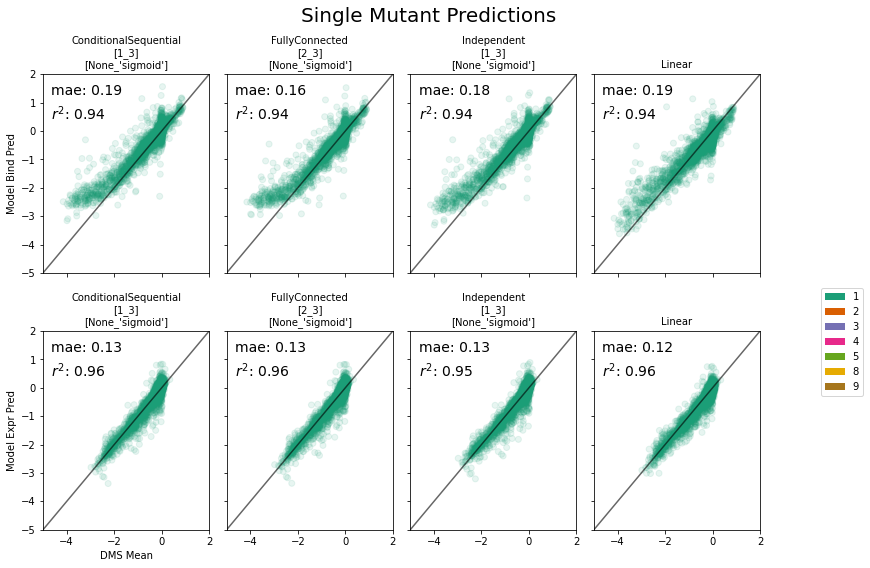

In [205]:
# for dataset, info in subsets.items():    
voi = fmvs.query("n_aa_substitutions == 1")
fig, ax = plt.subplots(
    nrows=2,
    ncols=len(best_models),
    figsize=[12, 8],
    sharex=True, 
    sharey=True
)
for ax_col, (idx, model_row) in enumerate(best_models.iterrows()):
    for ax_row, pheno in enumerate(["bind_CGG", "expr"]):

        axes = ax[ax_row, ax_col]
        model_pred_str = f"{model_row.model_id}-delta-{pheno}"
        ground_truth_str = f"delta_{pheno}"
        preds = voi[[ground_truth_str, model_pred_str, "n_aa_substitutions"]].dropna()
        if len(preds) == 0: continue
        x = preds[ground_truth_str]
        y = preds[model_pred_str]
        mae = model_row[f"single_mutants_{pheno}_mae"]
        r = model_row[f"single_mutants_{pheno}_corr"]
        c = [colors[n_aa_m] for n_aa_m in preds.n_aa_substitutions]
        axes.plot([-5, 2], [-5, 2], c="black", alpha=0.6)
        axes.scatter(x, y, alpha=0.1, c=c)
        
        title = (
            '\n'.join(model_row.model_string.split(';')) 
            #+ "\n" + model_row.monotonic
        )
             
        axes.set_title(title, size=10)
        axes.text(
            0.05, 0.95, f'mae: {mae:.2f}', 
            transform=axes.transAxes, fontsize=14,
            verticalalignment='top'
        )
        axes.text(
            0.05, 0.85, f'$r^{2}$: {r:.2f}', 
            transform=axes.transAxes, fontsize=14,
            verticalalignment='top'
        )
        axes.set_xlim([-5, 2])
        axes.set_ylim([-5, 2])
        

ax[0, 0].set_ylabel("Model Bind Pred")
ax[1, 0].set_ylabel("Model Expr Pred")
ax[1, 0].set_xlabel("DMS Mean")
plt.legend(recs,colors.keys(),loc=4, bbox_to_anchor =(1.65, 0.65))

fig.suptitle("Single Mutant Predictions", size=20)
plt.tight_layout()
# fig.savefig("sme.png")
fig.savefig(f"{plot_dir}/scatter_gt_single_mut.png")
plt.show()

**Now look at the DMS mean delta phenotypes as a function of latent phenotype, plotted on top of the non linearity function for the two independent derived models**

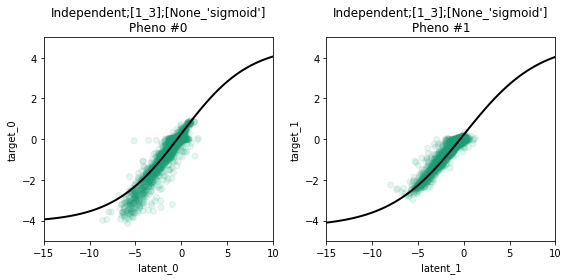

In [206]:
plot_ind_non_lin(voi, saveas=f"{plot_dir}/non_lin_single_mut.png", s_alpha=0.1)

In [207]:
#model = moij[0]
# mono = best_models.loc[moi[0], "model"]
# for param in mono.monotonic_params_from_latent_space():
#     print(param)

## 11. All Training data

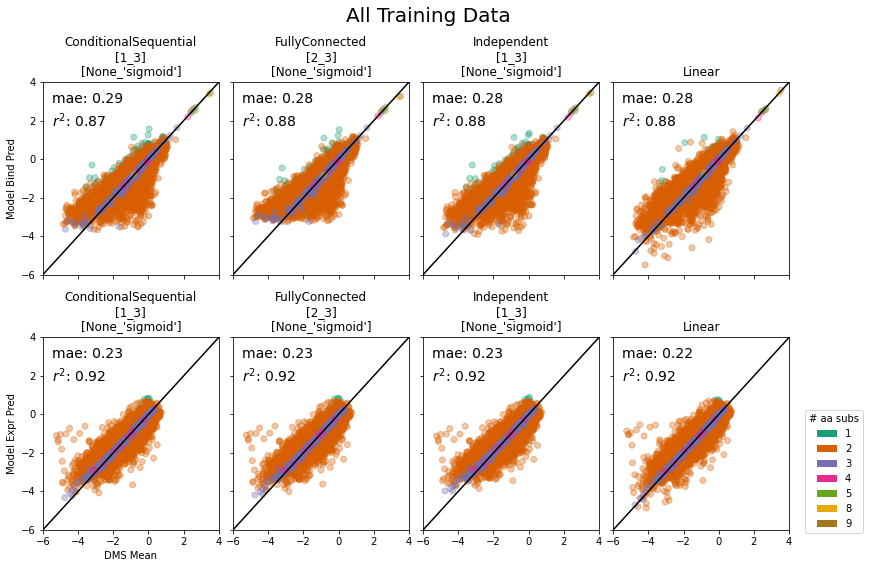

In [208]:
# for dataset, info in subsets.items():    
# voi = fmvs.query("n_aa_substitutions == 1")
c1, c2 = -6, 4

voi = fmvs.query("split_set == 'train'")
# voi = voi.assign(color = voi.n_aa_substitutions.astype("category").cat.codes)

fig, ax = plt.subplots(
    nrows=2,
    ncols=len(best_models),
    figsize=[12, 8],
    sharex=True, 
    sharey=True
)
for ax_col, (idx, model_row) in enumerate(best_models.iterrows()):
    for ax_row, pheno in enumerate(["bind_CGG", "expr"]):

        axes = ax[ax_row, ax_col]
        model_pred_str = f"{model_row.model_id}-delta-{pheno}"
        ground_truth_str = f"delta_{pheno}"
        preds = voi[
            [ground_truth_str, model_pred_str, "n_aa_substitutions"]
        ].sort_values(by="n_aa_substitutions").dropna()
        if len(preds) == 0: continue
        x = preds[ground_truth_str]
        y = preds[model_pred_str]
        mae = MAE(x, y)
        r = sp.pearsonr(x, y)[0]
        c = [colors[n_aa_m] for n_aa_m in preds.n_aa_substitutions]
        sc = axes.scatter(
            x, y, 
            alpha=0.35, 
            c=c
        )
        axes.plot([c1, c2], [c1, c2],c="black")
        
        title = (
            '\n'.join(model_row.model_string.split(';')) 
#             + "\n" + model_row.monotonic
        )
        
        axes.set_title(title)
        axes.text(
            0.05, 0.95, f'mae: {mae:.2f}', 
            transform=axes.transAxes, fontsize=14,
            verticalalignment='top'
        )
        axes.text(
            0.05, 0.85, f'$r^{2}$: {r:.2f}', 
            transform=axes.transAxes, fontsize=14,
            verticalalignment='top'
        )
        axes.set_xlim([c1, c2])
        axes.set_ylim([c1, c2])
        

ax[0, 0].set_ylabel("Model Bind Pred")
ax[1, 0].set_ylabel("Model Expr Pred")
ax[1, 0].set_xlabel("DMS Mean")

fig.suptitle("All Training Data", size=20)
plt.legend(
    recs,colors.keys(),
    title = "# aa subs",
    bbox_to_anchor =(1.45, 0.65)
)
plt.tight_layout()
# fig.savefig("sme.png")
fig.savefig(f"{plot_dir}/scatter_gt_all_train.png")
plt.show()

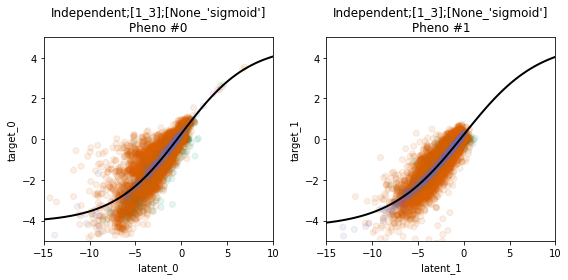

In [209]:
# plot_ind_non_lin(voi, saveas="non_lin_all_train.png")
plot_ind_non_lin(voi, saveas=f"{plot_dir}/non_lin_all_train.png", s_alpha=0.1)

## 12. Held Out Testing Dataset Eval

In [210]:
# addititive model
# def additive()
sme = fmvs.query("n_aa_substitutions == 1 & library == 'dms'").set_index("aa_substitutions")

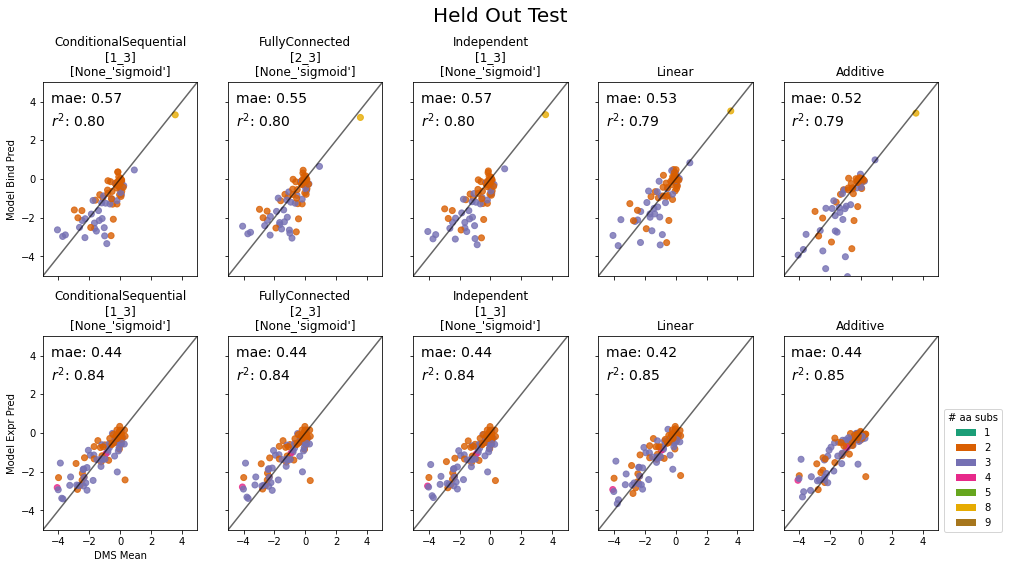

In [211]:
# for dataset, info in subsets.items():    
voi = fmvs.query("split_set == 'test'").copy()
fig, ax = plt.subplots(
    nrows=2,
    ncols=len(best_models) + 1, # additive
    figsize=[14, 8],
    sharex=True, 
    sharey=True
)
for ax_col, (idx, model_row) in enumerate(best_models.iterrows()):
    for ax_row, pheno in enumerate(["bind_CGG", "expr"]):
        axes = ax[ax_row, ax_col]
        model_pred_str = f"{model_row.model_id}-delta-{pheno}"
        ground_truth_str = f"delta_{pheno}"
        preds = voi[[ground_truth_str, model_pred_str, "n_aa_substitutions"]].dropna()
        if len(preds) == 0: continue
        x = preds[ground_truth_str]
        y = preds[model_pred_str]
        r = model_row[f"held_out_test_{pheno}_corr"]
        mae = model_row[f"held_out_test_{pheno}_mae"]
        c = [colors[n_aa_m] for n_aa_m in preds.n_aa_substitutions]
        
        axes.plot([-5, 5], [-5, 5], c="black", alpha=0.6)
        axes.scatter(x, y, alpha=0.8, c=c)
   
        title = '\n'.join(model_row.model_string.split(';'))
        axes.set_title(title)
        axes.text(
            0.05, 0.95, f'mae: {mae:.2f}', 
            transform=axes.transAxes, fontsize=14,
            verticalalignment='top'
        )
        axes.text(
            0.05, 0.85, f'$r^{2}$: {r:.2f}', 
            transform=axes.transAxes, fontsize=14,
            verticalalignment='top'
        )
        axes.set_xlim([-5, 5])
        axes.set_ylim([-5, 5])

for ax_row, pheno in enumerate(["bind_CGG", "expr"]):
    axes = ax[ax_row, ax_col+1]
    ground_truth_str = f"delta_{pheno}"
    model_pred_str = f"additive_delta_{pheno}"  
    mutations = voi.aa_substitutions.apply(lambda aa_sub: aa_sub.split())
    voi[f"additive_delta_{pheno}"] = [sme.loc[subs, f"delta_{pheno}"].sum() for subs in mutations]
    preds = voi[[ground_truth_str, model_pred_str, "n_aa_substitutions"]].dropna()
    x = preds[ground_truth_str]
    y = preds[model_pred_str]
    mae = MAE(x, y)
    r=sp.pearsonr(x, y)[0]
    c = [colors[n_aa_m] for n_aa_m in preds.n_aa_substitutions]
    
    axes.plot([-5, 5], [-5, 5], c="black", alpha=0.6)
    axes.scatter(x, y, alpha=0.8,c=c)
    title = 'Additive'
    axes.set_title(title)
    axes.text(
        0.05, 0.95, f'mae: {mae:.2f}', 
        transform=axes.transAxes, fontsize=14,
        verticalalignment='top'
    )
    axes.text(
        0.05, 0.85, f'$r^{2}$: {r:.2f}', 
        transform=axes.transAxes, fontsize=14,
        verticalalignment='top'
    )
    axes.set_xlim([-5, 5])
    axes.set_ylim([-5, 5])

ax[0, 0].set_ylabel("Model Bind Pred")
ax[1, 0].set_ylabel("Model Expr Pred")
ax[1, 0].set_xlabel("DMS Mean")
fig.suptitle("Held Out Test", size=20)
plt.legend(
    recs,colors.keys(),
    title = "# aa subs",
    bbox_to_anchor =(1.45, 0.65)
)
plt.tight_layout()

fig.savefig(f"{plot_dir}/scatter_gt_held_out.png")
plt.show()

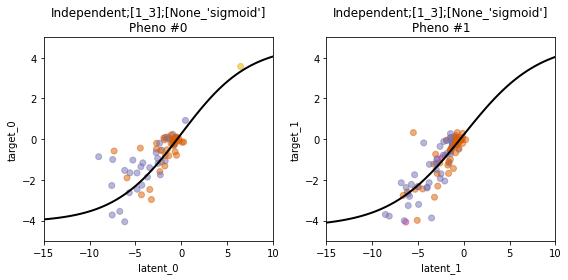

In [212]:
plot_ind_non_lin(voi, saveas=f"{plot_dir}/non_lin_all_test.png", s_alpha=0.5)

## 13. Calibrated Octet Testing Dataset Eval

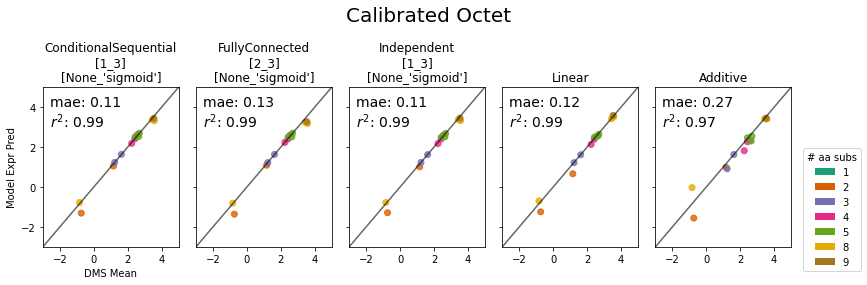

In [213]:
# for dataset, info in subsets.items():    
voi = fmvs.query("library == 'octet'").copy()
fig, ax = plt.subplots(
    nrows=1,
    ncols=len(best_models) + 1, # additive
    figsize=[12, 4],
    sharex=True, 
    sharey=True
)
for ax_col, (idx, model_row) in enumerate(best_models.iterrows()):
    axes = ax[ax_col]
    model_pred_str = f"{model_row.model_id}-delta-bind_CGG"
    ground_truth_str = f"delta_bind_CGG"
    preds = voi[[ground_truth_str, model_pred_str, "n_aa_substitutions"]].dropna()
    if len(preds) == 0: continue
    x = preds[ground_truth_str]
    y = preds[model_pred_str]
    
    r = model_row[f"dms_calibrated_octet_bind_CGG_corr"]
    mae = model_row[f"dms_calibrated_octet_bind_CGG_mae"]
    c = [colors[n_aa_m] for n_aa_m in preds.n_aa_substitutions]
    
    
    axes.plot([-3, 5], [-3, 5], c="black", alpha=0.6)
    axes.scatter(x, y, alpha=0.8,c=c)

    title = '\n'.join(model_row.model_string.split(';'))
    axes.set_title(title)
    axes.text(
        0.05, 0.95, f'mae: {mae:.2f}', 
        transform=axes.transAxes, fontsize=14,
        verticalalignment='top'
    )
    axes.text(
        0.05, 0.85, f'$r^{2}$: {r:.2f}', 
        transform=axes.transAxes, fontsize=14,
        verticalalignment='top'
    )
    axes.set_xlim([-3, 5])
    axes.set_ylim([-3, 5])
    
axes = ax[ax_col+1]
ground_truth_str = f"delta_bind_CGG"
model_pred_str = f"additive_delta_bind_CGG"
mutations = voi.aa_substitutions.apply(lambda aa_sub: aa_sub.split())
voi[f"additive_delta_bind_CGG"] = [sme.loc[subs, f"delta_bind_CGG"].sum() for subs in mutations]
preds = voi[[ground_truth_str, model_pred_str, "n_aa_substitutions"]].dropna()
x = preds[ground_truth_str]
y = preds[model_pred_str]
mae = MAE(x, y)
r=sp.pearsonr(x, y)[0]
c = [colors[n_aa_m] for n_aa_m in preds.n_aa_substitutions]


axes.plot([-3, 5], [-3, 5], c="black", alpha=0.6)
axes.scatter(x, y, alpha=0.8,c=c)
axes.set_title('Additive')
axes.text(
    0.05, 0.95, f'mae: {mae:.2f}', 
    transform=axes.transAxes, fontsize=14,
    verticalalignment='top'
)
axes.text(
    0.05, 0.85, f'$r^{2}$: {r:.2f}', 
    transform=axes.transAxes, fontsize=14,
    verticalalignment='top'
)
axes.set_xlim([-3, 5])
axes.set_ylim([-3, 5])

ax[0].set_ylabel("Model Bind Pred")
ax[0].set_ylabel("Model Expr Pred")
ax[0].set_xlabel("DMS Mean")

fig.suptitle("Calibrated Octet", size=20)
plt.legend(
    recs,colors.keys(),
    title = "# aa subs",
    bbox_to_anchor =(1.55, 0.65)
)

plt.tight_layout()
fig.savefig(f"{plot_dir}/scatter_gt_octet.png")
plt.show()

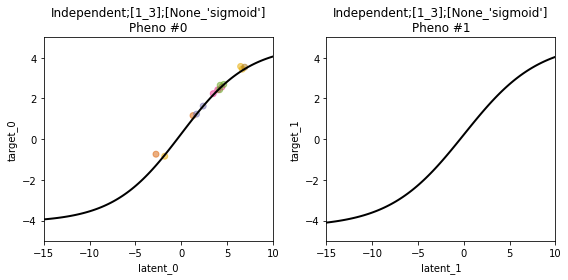

In [214]:
plot_ind_non_lin(voi, saveas=f"{plot_dir}/non_lin_all_octet.png", s_alpha=0.5)

## 14. Observed Replay Data Model Comparison

Now, we'll compar the model predictions on replay data

In [215]:
# load the replay observed seqs data
observed_seqs  = pd.read_csv(replay_observed_seqs_path)
observed_seqs

,ID_HK,well,HK_key_plate,HK_key_mouse,HK_key_gc,HK_key_node,HK_key_cell_type,aa_substitutions_IMGT,aa_sequence,delta_bind_CGG_FVS_additive,...,fasta_header_HC,fasta_header_LC,fasta_seq_HC,fasta_seq_LC,partis_sequence_HC,partis_sequence_LC,seq_aa_HC,seq_aa_LC,seq_nt_HC,seq_nt_LC
0,220517P08C05HK,C05,118,11,118,LB,GC,S64(H)T,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.03998,...,PR-1-9.220517.P08.C05.H.R.1-139,PR-1-9.220517.P08.C05.K.R.1-113,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTC...,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,DIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWYQQKPGQSPKA...,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...
1,220517P08H03HK,H03,118,11,118,LB,GC,S20(H)T Y58(H)H Y87(H)F A105(H)G Y42(L)F Q105(...,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.41060,...,PR-1-9.220517.P08.H03.H.R.1-5,PR-1-9.220517.P08.H03.K.R.1-118,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTC...,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,DIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWFQQKPGQSPKA...,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...
2,220517P08H05HK,H05,118,11,118,LB,GC,K49(H)R S57(H)N K84(H)R Y42(L)C N108(L)Y L124(...,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.75889,...,PR-1-9.220517.P08.H05.H.R.1-5,PR-1-9.220517.P08.H05.K.R.1-137,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTC...,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNRLE...,DIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWCQQKPGQSPKA...,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...
3,220517P08C07HK,C07,118,11,118,LB,GC,S20(H)T Y58(H)H A105(H)G Y42(L)F Q105(L)H S109...,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,1.20474,...,PR-1-9.220517.P08.C07.H.R.1-9,PR-1-9.220517.P08.C07.K.R.1-169,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTC...,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,DIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWFQQKPGQSPKA...,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...
4,220517P08H06HK,H06,118,11,118,LB,GC,S20(H)T I56(H)V Y58(H)H S64(H)T A105(H)G Y42(L...,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,1.17960,...,PR-1-9.220517.P08.H06.H.R.1-7,PR-1-9.220517.P08.H06.K.R.1-127,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GTGTTAATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTC...,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAG...,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,DIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWFQQKPGQSPKA...,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcagtag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,210923P02A02HK,A02,18,1,20,LB,GC,T35(H)S T65(H)I N92(H)K T96(H)I A105(H)G V15(L...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.41378,...,PR-1-1.210923.P02.A02.H.R.1-191,PR-1-1.210923.P03.A02.K.R.1-538,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTC...,GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTC...,GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAATAA...,EVQLQESGPSLVKPSQTLSLTCSVTGDSISSGYWNWIRKFPGNKLE...,DIVMTQSQKFMSTSIRDRVSVTCKASQNVGTNVAWYQQKPGQSPKA...,gaggtgcagcttcaggagtcaggacctagcctcgtgaaaccttctc...,gacattgtgatgactcagtctcaaaaattcatgtccacatcaataa..

In [216]:
observed_seqs.columns

Index(['ID_HK', 'well', 'HK_key_plate', 'HK_key_mouse', 'HK_key_gc',
       'HK_key_node', 'HK_key_cell_type', 'aa_substitutions_IMGT',
       'aa_sequence', 'delta_bind_CGG_FVS_additive', 'delta_expr_FVS_additive',
       'delta_psr_FVS_additive', 'delta_bind_CGG_FMVS_additive',
       'delta_expr_FMVS_additive', 'delta_psr_FMVS_additive',
       'delta_bind_CGG_tdms_model_pred', 'delta_expr_tdms_model_pred',
       'delta_psr_tdms_model_pred', 'delta_bind_CGG_tdms_linear_model_pred',
       'delta_expr_tdms_linear_model_pred', 'delta_psr_tdms_linear_model_pred',
       'n_mutations_HC', 'n_mutations_LC', 'IgH_mutations', 'IgK_mutations',
       'isotype_HC', 'isotype_LC', 'ID_HC', 'ID_LC', 'Productive_HC',
       'Productive_LC', 'V_HC', 'V_LC', 'D_HC', 'D_LC', 'J_HC', 'J_LC',
       'AAjunction_HC', 'AAjunction_LC', 'locus_HC', 'locus_LC',
       'miseq_plate_HC', 'miseq_plate_LC', 'barcode_HC', 'barcode_LC',
       'row_HC', 'row_LC', 'column_HC', 'column_LC', 'chain_HC', 'chain_LC

In [217]:
pos_df = pd.read_csv(
        naive_sites_path,
        dtype=dict(site=pd.Int16Dtype()),
        index_col="site_scFv",
    )
# naive_hk_bcr_nt = ("GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCT"
#                    "CAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGA"
#                    "TCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTA"
#                    "CTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTAC"
#                    "CTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATG"
#                    "TCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGACATTGTGATGACtCAGTCTCAAAAATT"
#                    "CATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACT"
#                    "AATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCT"
#                    "ACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCAC"
#                    "CATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCT"
#                    "CTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAA")
# len(naive_hk_bcr_nt)

def aa(sequence, frame):
    """Amino acid translation of nucleotide sequence in frame 1, 2, or 3."""
    return Seq(
        sequence[(frame - 1): (frame - 1
                               + (3 * ((len(sequence) - (frame - 1)) // 3)))]
    ).translate()

igh_frame = 1
igk_frame = 1
igk_idx = 336
# naive_igh_aa = aa(naive_hk_bcr_nt[:igk_idx], igh_frame)
# naive_igk_aa = aa(naive_hk_bcr_nt[igk_idx:], igk_frame)

# Well make a prediction for each of the observed sequences
for idx, row in observed_seqs.iterrows():

    # Infer mutations from nt seq available
    igh_aa = aa(row.seq_nt_HC, igh_frame)
    igk_aa = aa(row.seq_nt_LC, igk_frame)

    # Make the aa seq for tdms 
    aa_tdms = pos_df.amino_acid.copy()
    aa_tdms.iloc[pos_df.chain == "H"] = igh_aa
    # note: replay light chains are shorter than dms seq by one aa
    aa_tdms.iloc[(pos_df.chain == "L") & (pos_df.index < pos_df.index[-1])] = igk_aa
    aa_tdms_seq = "".join(aa_tdms)
    observed_seqs.loc[idx, "aa_sequence"] = aa_tdms_seq

In [218]:
observed_seqs["n_aa_subs"] = observed_seqs['n_mutations_HC'] + observed_seqs["n_mutations_LC"]

In [34]:
a_model = model_df.loc[0, "model"]
aa_seq_one_hot = torch.stack(
    list(observed_seqs.aa_sequence.apply(lambda seq: a_model.seq_to_binary(seq)).values)
)
aa_seq_one_hot

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [35]:
bind_cols, expr_cols = [], []
for idx, row in tqdm(best_models.iterrows(), total=len(best_models)):
    model_string = '\n'.join(row.model_string.split(";"))
    bind_str = f"{model_string}\n delta bind"
    expr_str = f"{model_string}\n delta expr"
    bind_cols.append(bind_str)
    expr_cols.append(expr_str)

    observed_seqs[[bind_str, expr_str]] = row.model(aa_seq_one_hot).detach().numpy()
    observed_seqs["model_string"] = row.model_string
observed_seqs

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 40.49it/s]


,ID_HK,well,HK_key_plate,HK_key_mouse,HK_key_gc,HK_key_node,HK_key_cell_type,aa_substitutions_IMGT,aa_sequence,delta_bind_CGG_FVS_additive,...,n_aa_subs,ConditionalSequential\n[1_3]\n[None_'relu']\n delta bind,ConditionalSequential\n[1_3]\n[None_'relu']\n delta expr,model_string,FullyConnected\n[2_6]\n[None_'relu']\n delta bind,FullyConnected\n[2_6]\n[None_'relu']\n delta expr,Independent\n[1_3]\n[None_'relu']\n delta bind,Independent\n[1_3]\n[None_'relu']\n delta expr,Linear\n delta bind,Linear\n delta expr
0,220517P08C05HK,C05,118,11,118,LB,GC,S64(H)T,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.03998,...,3.0,-0.055751,-0.957569,Linear,0.180018,-0.589869,-0.052064,-1.006655,-0.061463,-0.794567
1,220517P08H03HK,H03,118,11,118,LB,GC,S20(H)T Y58(H)H Y87(H)F A105(H)G Y42(L)F Q105(...,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.41060,...,10.0,-0.048574,-0.369719,Linear,1.174911,-0.418124,-0.591023,0.000000,1.058006,-0.073302
2,220517P08H05HK,H05,118,11,118,LB,GC,K49(H)R S57(H)N K84(H)R Y42(L)C N108(L)Y L124(...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNRLE...,0.75889,...,11.0,1.021683,-1.544494,Linear,0.597061,-0.954395,0.563843,-0.493724,1.392734,-0.662441
3,220517P08C07HK,C07,118,11,118,LB,GC,S20(H)T Y58(H)H A105(H)G Y42(L)F Q105(L)H S109...,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,1.20474,...,8.0,1.498338,-0.663241,Linear,1.423093,-0.047295,1.355630,-0.116588,1.782620,-0.166945
4,220517P08H06HK,H06,118,11,118,LB,GC,S20(H)T I56(H)V Y58(H)H S64(H)T A105(H)G Y42(L...,EVQLQESGPSLVKPSQTLTLTCSVTGDSITSGYWNWIRKFPGNKLE...,1.17960,...,11.0,1.384670,-1.590090,Linear,1.589889,-0.625078,-0.058386,-0.750789,1.542101,-0.883022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,210923P02A02HK,A02,18,1,20,LB,GC,T35(H)S T65(H)I N92(H)K T96(H)I A105(H)G V15(L...,EVQLQESGPSLVKPSQTLSLTCSVTGDSISSGYWNWIRKFPGNKLE...,0.41378,...,11.0,-1.232212,-1.000106,Linear,-0.286515,-1.816596,-1.632386,-0.174469,-0.994287,-0.337272
6787,210923P02A12HK,A12,18,1,20,LB,GC,Y88(H)N N92(H)K A105(H)G,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.35079,...,4.0,0.243425,-0.203652,Linear,-0.059340,-0.539061,0.124883,0.000000,0.350789,-0.051638
6788,210923P02C08HK,C08,18,1,20,LB,GC,T96(H)I Y42(L)S L116(L)V,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,0.07793,...,5.0,-0.327071,-1.536029,Linear,0.192052,-1.259273,-0.111666,-1.263182,0.130636,-1.115292
6789,210923P02F01HK,F01,18,1,20,LB,GC,Y66(H)H N92(H)K A105(H)G K24(L)T Q105(L)H K123...,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.22638,...,7.0,-0.431569,-0.579700,Linear,-0.392749,-1.097261,-0.547211,0.000000,-0.018434,-0.192334


In [36]:
bind_cols

["ConditionalSequential\n[1_3]\n[None_'relu']\n delta bind",
 "FullyConnected\n[2_6]\n[None_'relu']\n delta bind",
 "Independent\n[1_3]\n[None_'relu']\n delta bind",
 'Linear\n delta bind']

In [37]:
bind_cols += ['delta_bind_CGG_FVS_additive', 'delta_bind_CGG_FMVS_additive']

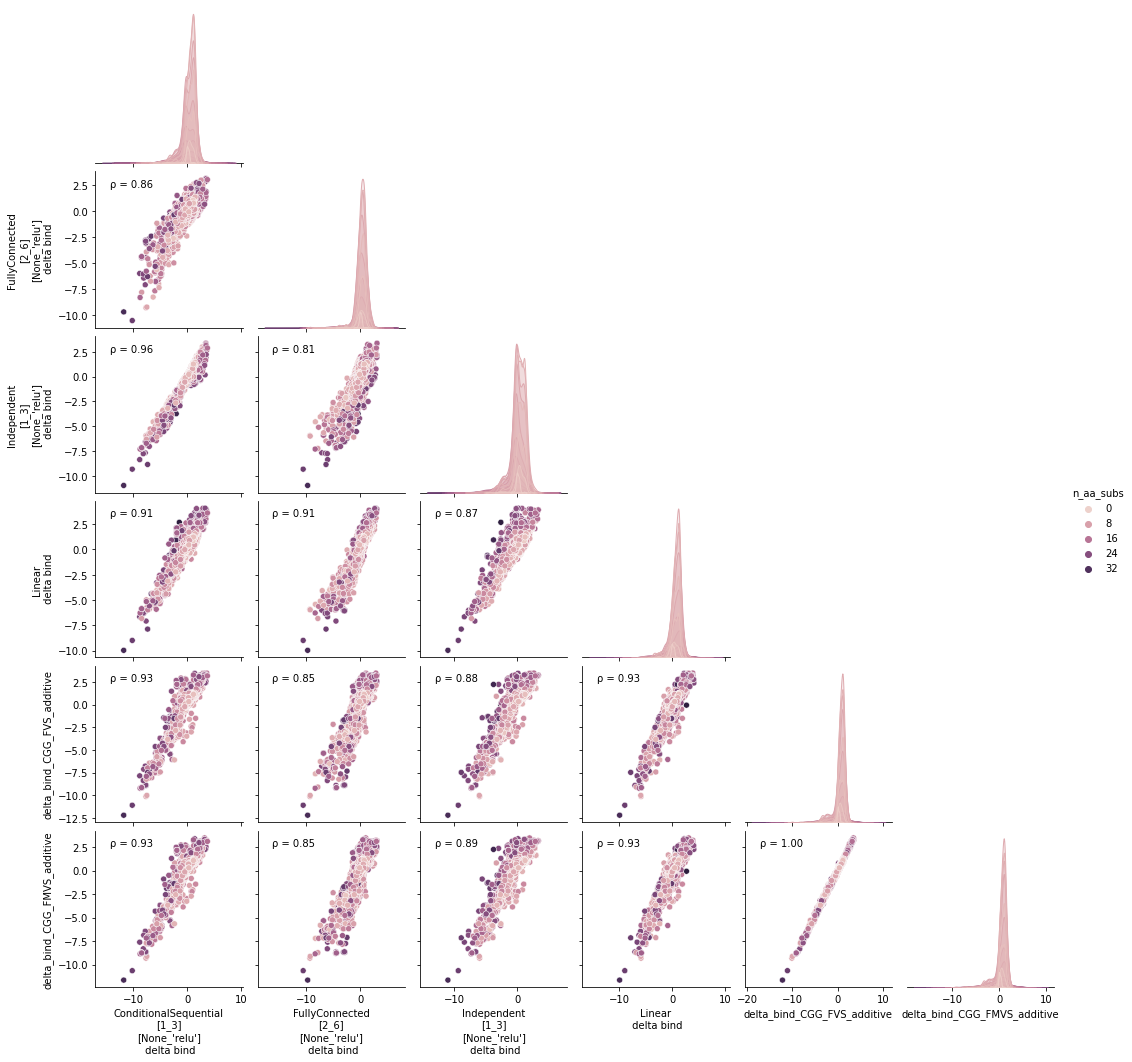

In [38]:
def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""

    df = pd.DataFrame({"x":x.values, "y":y.values}).dropna()
    if len(df) < 2: return
    r, _ = sp.pearsonr(df.x, df.y)
    
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g = sns.pairplot(
    observed_seqs, 
    vars=bind_cols,
    corner=True,
    hue="n_aa_subs"
)
g.map_lower(corrfunc)
g.savefig(f"{plot_dir}/pairplot-model-bind.png")
plt.show()

## 15. Tree Node Replay Data Model Comparison

In [39]:
gcreplay_node_data = pd.read_csv(replay_tree_seqs_path)
# gcreplay_node_data = pd.read_csv(replay_tree_seqs_path)

In [40]:
gcreplay_node_data.columns

Index(['PR', 'HK_key_mouse', 'HK_key_node', 'HK_key_gc', 'HK_key_cell_type',
       'name', 'parent_name', 'abundance', 'sampled_cell_ids',
       'n_mutations_HC', 'n_mutations_LC', 'IgH_mutations', 'IgK_mutations',
       'IgH_productive', 'IgK_productive', 'isotype', 'LBI', 'LBR',
       'descendant_abundance', 'IgH_nt_sequence', 'IgH_aa_sequence',
       'IgK_nt_sequence', 'IgK_aa_sequence', 'aa_sequence',
       'aa_substitutions_IMGT', 'delta_bind_CGG_FVS_additive',
       'delta_bind_CGG_FMVS_additive', 'delta_bind_CGG_tdms_model_pred',
       'delta_bind_CGG_tdms_linear_model_pred', 'delta_expr_FVS_additive',
       'delta_expr_FMVS_additive', 'delta_expr_tdms_model_pred',
       'delta_expr_tdms_linear_model_pred', 'delta_psr_FVS_additive',
       'delta_psr_FMVS_additive', 'delta_psr_tdms_model_pred',
       'delta_psr_tdms_linear_model_pred'],
      dtype='object')

In [41]:
# np.all(gcreplay_node_data.aa_sequence == gcreplay_node_data.aa_tdms)

In [42]:
a_model = model_df.loc[0, "model"]
aa_seq_one_hot = torch.stack(
    list(gcreplay_node_data.aa_sequence.apply(lambda seq: a_model.seq_to_binary(seq)).values)
)
aa_seq_one_hot

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [43]:
bind_cols, expr_cols = [], []
for idx, row in tqdm(best_models.iterrows(), total=len(best_models)):
    model_string = '\n'.join(row.model_string.split(";"))
    bind_str = f"{model_string}\n delta bind"
    expr_str = f"{model_string}\n delta expr"
    bind_cols.append(bind_str)
    expr_cols.append(expr_str)

    gcreplay_node_data[[bind_str, expr_str]] = row.model(aa_seq_one_hot).detach().numpy()
    gcreplay_node_data["model_string"] = row.model_string
gcreplay_node_data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 49.54it/s]


,PR,HK_key_mouse,HK_key_node,HK_key_gc,HK_key_cell_type,name,parent_name,abundance,sampled_cell_ids,n_mutations_HC,...,delta_psr_tdms_linear_model_pred,ConditionalSequential\n[1_3]\n[None_'relu']\n delta bind,ConditionalSequential\n[1_3]\n[None_'relu']\n delta expr,model_string,FullyConnected\n[2_6]\n[None_'relu']\n delta bind,FullyConnected\n[2_6]\n[None_'relu']\n delta expr,Independent\n[1_3]\n[None_'relu']\n delta bind,Independent\n[1_3]\n[None_'relu']\n delta expr,Linear\n delta bind,Linear\n delta expr
0,PR1.9,11,LB,118,GC,naive,NaN,0,NaN,0,...,0.102810,0.000000,0.000000,Linear,0.000000,0.000000,0.000000,0.000000,-0.104513,-0.024121
1,PR1.9,11,LB,118,GC,seq30,naive,1,220517P08F06HK,2,...,-0.584438,-0.634425,-0.137916,Linear,-0.174066,-0.688491,-0.730814,-0.092541,-0.212808,-0.079756
2,PR1.9,11,LB,118,GC,seq19,naive,1,220517P08A06HK,0,...,-0.200786,1.093710,-0.678652,Linear,1.016872,0.322653,1.116871,0.000000,0.847609,-0.024685
3,PR1.9,11,LB,118,GC,7,naive,0,NaN,0,...,0.102810,0.000000,0.000000,Linear,0.000000,0.000000,0.000000,0.000000,-0.104513,-0.024121
4,PR1.9,11,LB,118,GC,9,naive,0,NaN,2,...,-1.212955,-0.092960,-1.154648,Linear,-0.379435,-1.638943,-0.068188,-0.781588,0.344877,-0.671643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565,PR1.1,1,LB,20,GC,seq20,seq34,1,210923P02H04HK,4,...,-1.112735,0.192025,-1.082991,Linear,0.344853,-0.646258,-0.036394,-0.696410,0.551520,-0.693328
7566,PR1.1,1,LB,20,GC,seq29,11,1,210923P02F02HK,3,...,-1.572429,-0.245705,-0.579360,Linear,-0.168731,-0.972022,-0.291964,-0.097250,0.388008,-0.340351
7567,PR1.1,1,LB,20,GC,seq15,11,1,210923P02E11HK,3,...,-1.136669,-0.766012,-0.337872,Linear,-0.210857,-0.762657,-0.870715,0.000000,-0.541433,-0.235217
7568,PR1.1,1,LB,20,GC,seq9,seq85,1,210923P02B08HK,5,...,-1.921011,-1.272633,-1.105199,Linear,-0.503590,-2.286027,-1.660300,-0.278547,-0.948880,-0.352827


In [44]:
gcreplay_node_data["n_aa_subs"] = gcreplay_node_data['n_mutations_HC'] + gcreplay_node_data["n_mutations_LC"]

In [45]:
bind_cols += ['delta_bind_CGG_FVS_additive', 'delta_bind_CGG_FMVS_additive']

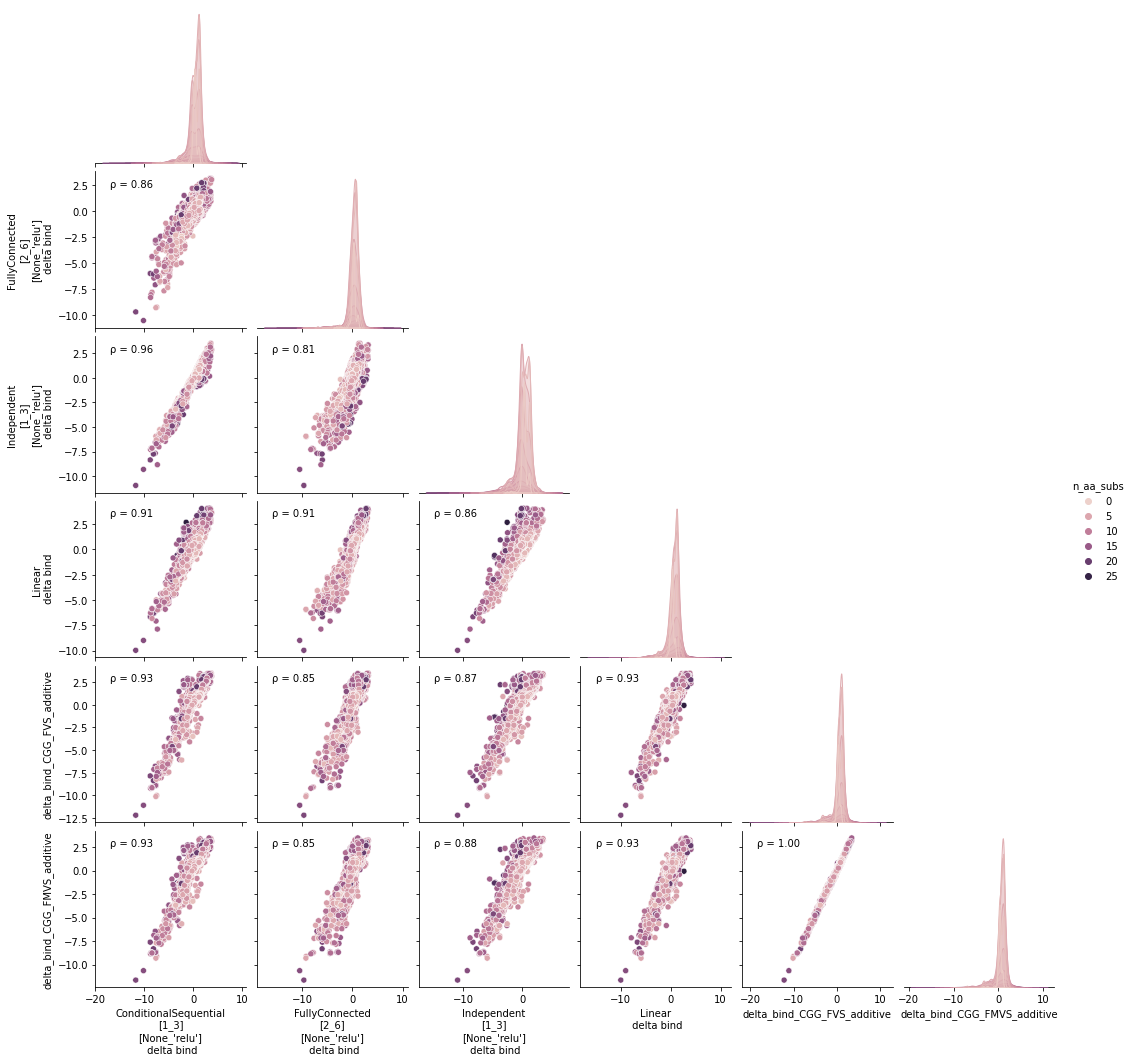

In [46]:
g = sns.pairplot(
    gcreplay_node_data, 
    vars=bind_cols,
    corner=True,
    hue="n_aa_subs"
)
g.map_lower(corrfunc)
g.savefig(f"{plot_dir}/pairplot-model-bind-nodes.png")
plt.show()